# QAOA Qiskit

For the Energy: 

$E(s_0, s_1, s_2) = - s_0 + \frac{1}{2} s_1 - \frac{1}{2} s_2 + \frac{1}{2} s_0 s_1 + \frac{1}{2} s_1 s_2$

Where the Cost Hamiltonian is written as 

$H_c = \frac{1}{2} z_0 z_1 + \frac{1}{2} z_1 z_2 - z_0 + \frac{1}{2} z_1 - \frac{1}{2} z_2$

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute, BasicAer
from qiskit.circuit import Parameter
import qiskit as qk
import numpy as np
import qutip as qtp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




nqubits: int = 3
p: int = 1

# initial value for gamma and beta
beta = np.random.rand(p)*np.pi
gamma = np.random.rand(p)*2*np.pi

def qaoa_circuit(gamma, beta):
    
    cr = ClassicalRegister(nqubits, "cr")
    qr = QuantumRegister(nqubits, "qr")
    qc = QuantumCircuit(qr, cr)
    #initial state 
    for i in range(nqubits):
        qc.h(i)
        
    qc.barrier()

    # implement the QAOA algorithm
    gamma1 = Parameter("$\\gamma$")
    beta1 = Parameter("$\\beta$")
    # hi = Parameter("h_i")
    # Jij = Parameter("J_ij")

    hi = [-1, 0.5, -0.5] 
    Jij = 0.5

    # 1. gamma, cost operator 
    for k in range(p):
        for i in range(0, nqubits):
            qc.rz(2 * gamma[k]* hi[i], i)
            # qc.rx(2 * gamma1* hi, i)

        for i in range(nqubits-1):
            qc.cx(i,i+1)
            qc.rz(2 * gamma[k]* Jij, i+1)
            # qc.rx(2 * gamma1* Jij, i+1)
            qc.cx(i,i+1)
        qc.barrier()

        # 2. beta, mixture operator

        for i in range(nqubits):
            qc.rx(2 * beta[k], i)
            # qc.rx(2 * beta1, i)

        qc.barrier()

    # qc.measure_all()
    qc.draw(output='mpl')
    return qc



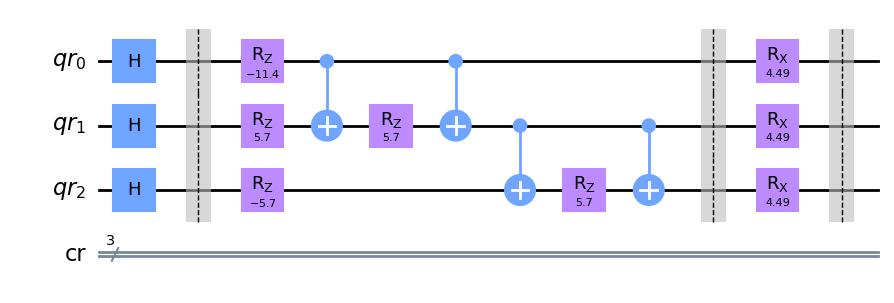

In [2]:
a = qaoa_circuit(gamma,beta)
a.draw(output='mpl')

In [3]:
# ----- Cost Hamiltonian ---------
HS = 2**nqubits                                         # hilbert space
iden = qtp.identity(2)                                  # identity 2x2
sigz = qtp.sigmaz()                                     # pauli_z 
def tensor_trip(A,B,C):
    return qtp.tensor(qtp.tensor(A,B),C)
def resize(x,n: int):
    new_dims = [[n], [n]]    
    return qtp.Qobj(x, dims=new_dims)
def costha():
    H1 = -1*tensor_trip(sigz,iden,iden)                   # - z_0
    H2 = 0.5*tensor_trip(iden, sigz,iden)                 # 1/2 z_1
    H3 = -0.5*tensor_trip(iden, iden, sigz)               # - 1/2 z_2
    H4 = 0.5*tensor_trip(sigz, sigz, iden)                # 1/2 z_0 z_1
    H5 = 0.5*tensor_trip(iden, sigz, sigz)                # 1/2 z_1 z_2
    return H1 + H2 + H3 + H4 + H5

Hamil = costha()
Hamil = resize(Hamil,HS)
print(Hamil)



Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2.]]


In [4]:
l1 = []
l2 = []
def f_expectation(param):
    gamma = param[:p]
    beta  = param[p:]
    qc1 = qaoa_circuit(gamma,beta)                     # my circuit
    backend = Aer.get_backend('statevector_simulator') # the device to run on
    result1 = backend.run(qc1).result()                # obtaining the result of the circuit 
    psi = result1.get_statevector()                    # state vector
    psi2 = psi.data                                    # transform to a np file
    psi3 = qtp.Qobj(psi2)                              # transform to a Qobj -> qutip
    exp1 = result1.get_counts()                        # getting the counts of the circuit
    l1.append(exp1)
    l2.append(qtp.expect(Hamil, psi3))
    return qtp.expect(Hamil, psi3)

gamma_range = np.linspace(0, 2*np.pi,50)
beta_range = np.linspace(0, np.pi,50)

Z = np.zeros((len(gamma_range), len(beta_range)))

for i, x in enumerate(gamma_range):
    # print(x)
    for j, y in enumerate(beta_range):
        l = [x,y]
        Z[i, j] = f_expectation(l)



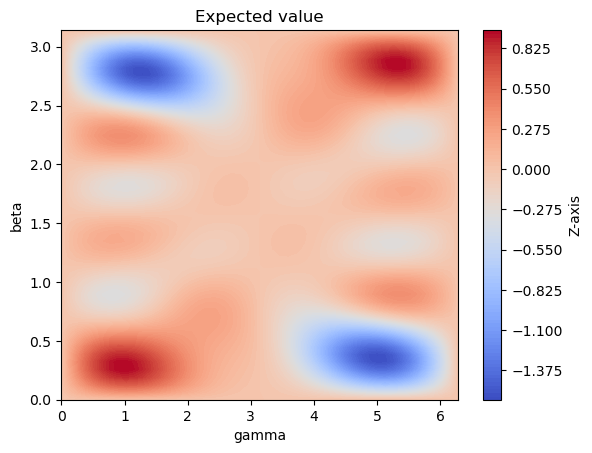

In [5]:
# Create a filled contour plot with a color bar
plt.contourf(gamma_range, beta_range, Z, cmap='coolwarm', levels=100)
plt.colorbar(label='Z-axis')

# Add labels and title
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title('Expected value')

# Show the plot
plt.show()

In [6]:
# Find the minimum value of Z and its indices
min_value = np.min(Z)
min_indices = np.unravel_index(np.argmin(Z), Z.shape)

# Extract the corresponding values of x and y
min_x = gamma_range[min_indices[0]]
min_y = beta_range[min_indices[1]]

# Print the minimum value and corresponding values of x and y
print("Minimum value of Z:", min_value)
print("Corresponding values of gamma and beta:", min_x, min_y)

Minimum value of Z: -1.5537183888675674
Corresponding values of gamma and beta: 5.513815677729024 0.6411413578754679


In [16]:
beta = np.random.rand(p)*np.pi
gamma = np.random.rand(p)*2*np.pi
x0 = [gamma[0], beta[0]]
print(x0)
res = minimize(f_expectation,
                      x0,
                      method='CG')
print(res)

[5.901817407223676, 0.9058828278034119]
     fun: -1.5689841976851078
     jac: array([ 1.08778477e-06, -1.43051147e-06])
 message: 'Optimization terminated successfully.'
    nfev: 33
     nit: 5
    njev: 11
  status: 0
 success: True
       x: array([5.57450969, 0.63260876])


In [17]:
print(res.x)
print(f_expectation(res.x))
print(l1[len(l1)-1])

[5.57450969 0.63260876]
-1.5689841976851078
{'000': 1}
